Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


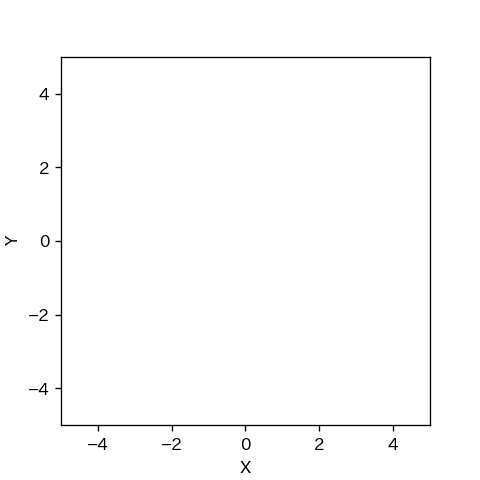

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red")
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


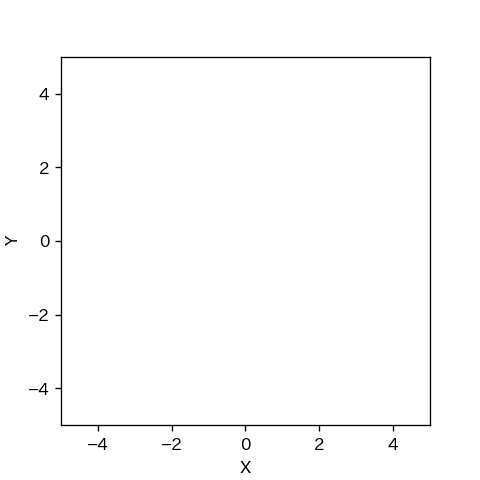

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_phantom(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [0.33283624 0.04901462 5.99241589] 推定値: [0.05845509 0.13716805 5.98529617] 誤差: 0.28819445600921717
1
1 真値: [-0.64925101  0.33163432  5.6883662 ] 推定値: [-0.73743522  0.71587627  5.61807448] 誤差: 0.3942313182513602
2
2 真値: [-1.14450087  2.13745475  4.37202288] 推定値: [-1.55801922  0.62467006  3.78996583] 誤差: 1.5682840832322034
3 真値: [-1.17285347  1.18603121  4.8709529 ] 推定値: [-0.83290882  0.25509887  4.91336828] 誤差: 0.9910587202908842
3
4 真値: [-0.57645166  0.29627365  5.18112124] 推定値: [-1.05073124  0.46261222  5.3137787 ] 誤差: 0.5026028597189323
4
5 真値: [-1.08165638  1.72265     4.68729725] 推定値: [-0.16572466  2.82563147  4.49278905] 誤差: 1.433701172022367
6 真値: [-0.6280704   0.21798639  5.91728347] 推定値: [-0.43263737  0.16378927  5.92877596] 誤差: 0.20280876238739953
5
7 真値: [-0.47793224  0.10845757  6.04104669] 推定値: [-0.54068582  0.55526786  5.86432468] 誤差: 0.4511955762149266
6
8 真値: [-1.08220002  1.17528642  4.62099097] 推定値: [-0.82653528  1.54594574  4.45772989] 誤差: 0.4502807932500064
7
9

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-1.20305765  0.76362435  4.97132588] 推定値: [-0.65075193  0.1182844   4.9599085 ] 誤差: 0.8494146561509336
16
21 真値: [-0.39131013 -0.02994898  5.71790207] 推定値: [-0.29226691 -0.21143459  5.51143362] 誤差: 0.2067524687109033
17
22 真値: [-1.34187762  0.94334163  4.94633353] 推定値: [-0.94443834  0.79248521  4.84325675] 誤差: 0.42510662321177345
18
23 真値: [-1.59823259  2.20802223  4.25578209] 推定値: [-1.74750138  2.29656235  4.26624732] 誤差: 0.17355264971928439
19
24 真値: [-1.45661753  1.01194015  4.86009572] 推定値: [-1.18057725  1.27988432  4.83023617] 誤差: 0.3846976965518658
20
25 真値: [-1.13775236  2.58701973  4.12115721] 推定値: [-1.59872531  3.12572896  4.32608437] 誤差: 0.7090160071735394
21
26 真値: [-0.84486891  0.24941305  5.45878767] 推定値: [-1.08021311  0.69826385  5.37456838] 誤差: 0.5068075930808942
22
27 真値: [-0.92101467  0.94623912  4.95447904] 推定値: [-0.93829745  1.12848318  4.86091552] 誤差: 0.18306172409914884
23
28 真値: [-0.92205551  1.63797216  4.64150442] 推定値: [-0.80110629  2.03166422  4.5514445